# Setup
- 필요한 라이브러리를 호출

In [1]:
import json
import math
import os
import urllib.request
import warnings
from urllib.error import HTTPError

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

# %matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

set_matplotlib_formats("svg", "pdf")  # For export
sns.set()

- 재현을 위해서 seed를 설정함
    - CPU와 다르게 같은 시드를 사용해도 다른 GPU 구조에서 다른 결과를 얻을 수 있음
- 다운로드 장소 설정이 필요함
    - `DATASET_PATH`: 데이터 다운로드 장소
    - `CHECKPOINT_PATH`: 학습된 모델의 가중치와 추가 파일을 저장하는 장소

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/Activation_Functions/")

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


- 사전 학습된 모델을 다운로드함

In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# Files to download
pretrained_files = [
    "FashionMNIST_elu.config",
    "FashionMNIST_elu.tar",
    "FashionMNIST_leakyrelu.config",
    "FashionMNIST_leakyrelu.tar",
    "FashionMNIST_relu.config",
    "FashionMNIST_relu.tar",
    "FashionMNIST_sigmoid.config",
    "FashionMNIST_sigmoid.tar",
    "FashionMNIST_swish.config",
    "FashionMNIST_swish.tar",
    "FashionMNIST_tanh.config",
    "FashionMNIST_tanh.tar",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                  e,
            )

# Common activation functions
- `torch.nn`에서 대부분 찾을 수 있지만 이해를 돕기 위해 활성함수를 직접 구현
- `nn.Module`을 상속했기 때문에 쉽게 네트워크에 결합할 수 있음
- 일부 활성 함수의 설정값을 저장하기 위해 `config` 딕셔너리를 사용할 것임

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

- PyTorch function에 구현된 torch.sigmoid / torch.tanh 혹은 nn.Sigmoid / nn.Tanh 을 사용할 수 있으며 아래는 직접 구현한 결과

In [5]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)
    
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()

class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)

class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

- ReLU와 ReLU의 변형
    - ReLU와: 더 깊은 네트워크 학습을 가능하게 하고, 넓은 범위의 값에 안정적인 기울기를 가짐
    - LeakyReLU: 음수를 0으로 설정하는 대신 작은 기울기로 대체
    - ELU: 음수 부분이 지수 감소하는 함수
    - Swish: 상대적으로 매끄럽고 단조적이지 않은 함수

In [6]:
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()


class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)


class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)


class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [7]:
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

## Visualizing activation functions
- `backward` 함수를 호출하여 그레디언트를 구할 수 있음

In [8]:
def get_grads(act_fn, x):
    """Computes the gradients of an activation function at specified positions.

    Args:
        act_fn: An object of the class "ActivationFunction" with an implemented forward pass.
        x: 1D input tensor.
    Returns:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_()  # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward()  # Summing results in an equal gradient flow to each element in x
    return x.grad  # Accessing the gradients of x by "x.grad"

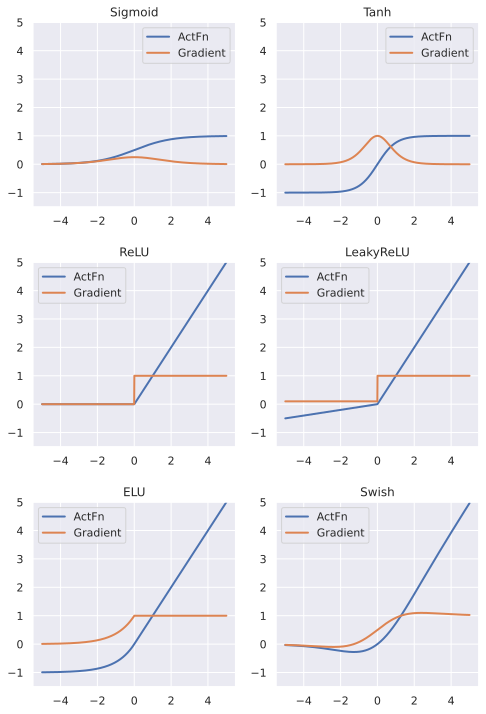

In [9]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    # Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())


# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)  # Range on which we want to visualize the activation functions
# Plotting
cols = 2
rows = math.ceil(len(act_fns) / float(cols))
fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, cols)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()